# Exploratory Text Analysis

In this notebook, we will explore the text data of the dataset, Checking the frequency of messages, intents, words, sentiments and other stuff. Will be a basic text analysis.

This notebook have a dataset in Portuguese as example, but it can be used in any language, you just need to change the raw data files.

## 1. Import

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

%matplotlib inline

## 2. Load data

#### 2.1 Examples

In [2]:
examples = pd.read_parquet('../data/raw/examples/raw.parquet')
examples.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 423 entries, 0 to 433
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  423 non-null    object
 1   phrase  423 non-null    object
dtypes: object(2)
memory usage: 9.9+ KB


#### 2.2 Responses

In [3]:
responses = pd.read_parquet('../data/external/responses-phrases.parquet')
responses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   target    24 non-null     object
 1   response  24 non-null     object
dtypes: object(2)
memory usage: 512.0+ bytes


#### 2.3 Sentiment Analysis

In [4]:
sentiment_analysis = pd.read_parquet('../data/external/sentiment-analysis-portuguese.parquet')
sentiment_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99384 entries, 0 to 99383
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  99384 non-null  object
 1   phrase  99384 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


## 3. Explore data

### 3.1 Data overview

In [5]:
examples.sample(10)

,target,phrase
84,baixar_app,Quero reativar o app
93,conhecer_contatos,Como entro em contato com o atendimento telefo...
220,liberar_dispositivo,Como faço para fazer a liberação por sms?
346,solicitar_acordo,Quero refinanciar meus empréstimos
301,alterar_senha,Como faço outra senha
31,acessar_conta,Como faço pra abrir meu app
97,conhecer_contatos,Conhecer contatos do Banco Magnus
398,quero_emprestimo,Como que eu faço para tomar um empréstimo com ...
153,desbloquear_app,Excedi números de tentativas e bloqueou o app
278,receber_extrato,Estou querendo o extrato do mês


In [6]:
responses.sample(10)

,target,response
3,alterar_limite_cartao,"Para alterar seu limite do cartão, primeiramen..."
20,quero_boleto,"Ok, verifiquei aqui que você quer o boleto. Nó..."
15,realizar_transferencia,Nosso App pode te ajudar nisso :). Na seção Tr...
16,receber_extrato,"Para receber seu extrato, acesse o App na seçã..."
10,encerrar_conta,É uma pena que deseja encerrar sua conta no no...
12,liberar_dispositivo,Claro! Podemos liberar seu dispositivo. Para i...
22,quero_emprestimo,Você pode realizar Empréstimos a qualquer mome...
6,conhecer_divida,"Humm... Para saber sua dívida, você precisa ac..."
17,alterar_senha,Certo!Alterar senha sempre é bom por questões ...
19,solicitar_acordo,"Ok, você pode solicitar um acordo pelo Aplicat..."


### 3.2 Intents Distribution

In [7]:
# count the number of phrases per intent
intents_count = examples.target.value_counts()

print('Number of different intents:', len(intents_count.index))
print('Number of phrases:', intents_count.sum())
print('Median number of phrases:', intents_count.median())

Number of different intents: 24
Number of phrases: 423
Median number of phrases: 16.5


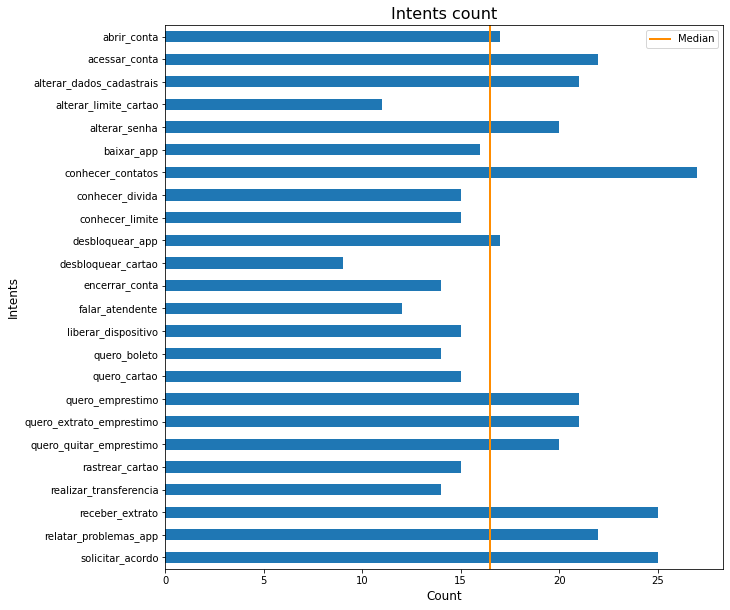

In [8]:
intents_count.sort_index(ascending = False).plot.barh(figsize = (10, 10))
plt.axvline(intents_count.median(), color = 'darkorange', linewidth = 2)
plt.title('Intents count', fontsize = 16)
plt.xlabel('Count', fontsize = 12)
plt.ylabel('Intents', fontsize = 12)
plt.legend(['Median'])
plt.show()

How is possible to note the dataset has unbalanced intents with different numbers of examples. So is necessary to balance our dataset with some techniques. In this case, we will use the technique of oversampling and data augmentation to generate more examples. Oversampling will be used when we will make the train data.

In [9]:
examples.phrase.value_counts()

Quero abrir uma conta no banco Banco Magnus           1
Como faço para ver valor do meu benefício             1
Tem como redefinir a senha por aqui?                  1
Não sei qual é a senha                                1
Preciso da senha para usar o app                      1
                                                     ..
Quero saber limites do meu cartão                     1
Gostaria do aumento de limite do cartão de crédito    1
Qual o limite que vai vir no cartão?                  1
Quero saber quanto posso gastar no cartão             1
Saber desconto do empréstimo                          1
Name: phrase, Length: 423, dtype: int64

### 3.3 Most used words

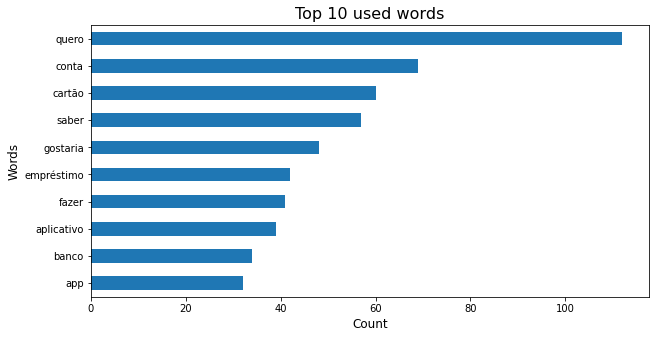

In [10]:
# listing words
words = examples.phrase.str.lower().apply(str.split).sum()

# reading portuguese stopwords
stopwords = open('../data/external/stopwords.csv', 'r').read().split('\n')

# removing stopwords
words = pd.Series(filter(lambda word: word not in stopwords, words))

top_ten_words = words.value_counts().head(10)
top_ten_words.plot.barh(figsize = (10, 5)).invert_yaxis()
plt.title('Top 10 used words', fontsize = 16)
plt.xlabel('Count', fontsize = 12)
plt.ylabel('Words', fontsize = 12)
plt.show()

The portuguese verb 'Quero' (Want) is the most user word in the dataset. So we can infer that the majority of intents are about Want something such as credit card, bills and other stuff.

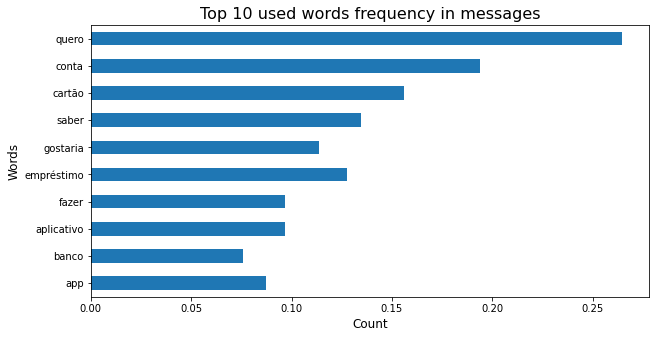

In [11]:
def word_frequency(word):
    return examples.phrase.str.lower().apply(lambda message: word in message).sum() / examples.shape[0]
    
top_ten_words_frequency = top_ten_words.index.to_series().apply(word_frequency)

top_ten_words_frequency.plot.barh(figsize = (10, 5)).invert_yaxis()
plt.title('Top 10 used words frequency in messages', fontsize = 16)
plt.xlabel('Count', fontsize = 12)
plt.ylabel('Words', fontsize = 12)
plt.show()

The verb 'Quero' (Want) appear in 26% of the dataset messages, followed by 'Conta' (Account) and 'Cartão' (Credit Card).

### 3.4 Sentiment Analysis

This dataset contains several tweets in Portuguese tagged as positive, negative or neutral. This dataset will be used to train a sentiment analysis model.

We have three classes of sentiment:
*  positive: messages that are positive, like "I am happy";
*  negative: messages that are negative, like "I am sad";
*  neutral: messages that are neutral, like "I am not sure".

In [12]:
sentiment_analysis.head(10)

,target,phrase
0,negative,Ja nem sei o que eu faço da minha vida :(
1,positive,"@UncleDeathMono vamos sim, só me chamar :)"
2,neutral,Você sabia? #curiosidade Caso Ciro Gomes vença...
3,positive,Ja devia de saber que tens papos com todas :))
4,negative,"Caralho, eu tô muito assustada. E pensar que m..."
5,negative,Anjo da minha vida :( https://t.co/K2pXx7Yx7X
6,positive,@maldsuado *andava a apanhar :)
7,positive,mais 1 mês sem nenhum real no bolso comendo o ...
8,negative,Recebi um áudio da minha vó dizendo que tá mui...
9,negative,oi @hyuckpetit te amo :((


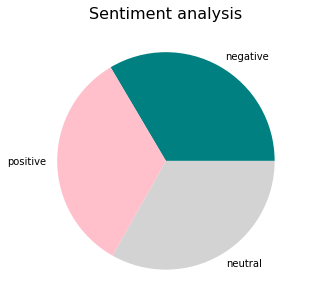

In [13]:
sentiment_analysis.target.value_counts().plot.pie(figsize = (10, 5), colors = ['teal', 'pink', 'lightgrey'])
plt.title('Sentiment analysis', fontsize = 16)
plt.ylabel('')
plt.show()

These classes are balanced, they have the same number of examples. This is a good sign, we don't need to balance our dataset.

In [14]:
sentiment_analysis[sentiment_analysis.phrase.str.contains('@')].sample(10)

,target,phrase
21898,negative,@sofalas Oh vou sim :(( eu fico a tomar conta ...
18139,negative,@karlatimes e você é o amor da minha :(
2515,negative,"@ifshawnsttay ah naaao :(, ficou muito lindo"
75560,negative,@lihvinha nesses dois não existe um menos pior...
11934,positive,@rr4gang nada :) kkkk
56628,neutral,O #tbt de hoje é com ela @meelzitha; pq a vitó...
48180,positive,@sejehomi Até falando trem e aperriando a pobr...
98750,negative,@rosselette @hyuuve HSUTTHEHFUCCJKDUP esto ya ...
21749,negative,@sichrng eu? quero? gritar?:(
43223,negative,@Any_CedC RAIOS :(


Tweets contain some words with '@' and '#' characters. These characters are used to tag the tweets as a user mention or a hashtag. We need to drop these words. In addition, some words are not useful, like '&gt' and 'https' (URL). We need to drop these words.

We will do it to minimize the number of words in our train dataset.